In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

from skimage import io
from skimage.color import gray2rgb
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
sns.set(style='white')

import keras.backend as K
from keras.models import Model
from keras.applications import vgg16, vgg19, inception_v3, resnet50
from keras.utils import np_utils
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from keras import optimizers

neu_root = 'D:\Python\CV Project\defect'

Using TensorFlow backend.


In the Northeastern University (NEU) surface defect database, six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc).
The database includes 1,800 grayscale images: 300 samples each of six different kinds of typical surface defects. The origeinal resolution of each image is 200x200 pixels. 900 images will be used for train images and the rest 600 images will be used for test images. The NEU surface defect database includes two difficult challenges: 1.The intra-class defects existing large differences in appearance while the inter-class defects have similar aspects; 2. The defect images suffer from the influence of illumination and material changes. 

In this project, we will implement transfer learning for this defect database classification problem, i.e. we will build our model on the top of pre-trained image classification models. Four image classification pre-trained models will be compared:
1. VGG16
2. VGG19
3. InceptionV3
4. ResNet50

It turns out that the highest accuracy is achieved when using VGG16 and VGG19, the highest accuracy is about 99%.

In [2]:
# load train and test file names
def load_labels(filepath):
    with open(filepath, 'r') as f:
        return [line.strip() for line in f]


train_files = load_labels(os.path.join(neu_root, 'train.txt'))
test_files = load_labels(os.path.join(neu_root, 'test.txt'))

In [3]:
# load images and labels
def load_images(image_files):
    """ load images into numpy array """

    images = [io.imread(os.path.join(neu_root, 'data', p)) for p in image_files]
    images = np.array(images)

    get_image_class = lambda path: path.split('_')[0]
    labels = list(map(get_image_class, image_files))
    return np.array(images), labels

train_images, train_labels = load_images(train_files)
test_images, test_labels = load_images(test_files)


label_dict = {label: idx
              for idx, label in enumerate(sorted(set(train_labels)))}

y_train = np.array([label_dict[label] for label in train_labels])
y_test = np.array([label_dict[label] for label in test_labels])

# 1.VGG16

The structure of vgg16 is as below. 

In [4]:
model = vgg16.VGG16(weights=None)
print("model structure: ", model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
def preprocess_images_vgg16(images):
    """ expect a 3D array containing grayscale uint8 images """
    
    # resize images with scipy
    I = np.array([resize(image, (224,224)) for image in images])
    
    # convert to RGB and apply imagenet preprocessing
    I = gray2rgb(I).astype(np.float32)

    return vgg16.preprocess_input(I)


def vgg16_layer(output_name='fc1'):
    # Note: currently hippolyta compute nodes cannot access user home directories,
    # and do not have direct internet access.
    # use full paths to NFS filesystem endpoints (not symlinks)
    # keras pretrained model weight files are here:
    KERAS_ROOT = 'D:\Python\CV Project\defect'
    weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    weights_path = os.path.join(KERAS_ROOT, 'models', weights_file)

    # initialize network with random weights, and load from hdf5
    cnn = vgg16.VGG16(include_top=True, weights=None)
    cnn.load_weights(filepath=weights_path)

    model = Model(inputs=cnn.input,outputs=cnn.get_layer(output_name).output)
    return model


def cached_forward_pass_vgg16(images, phase='train', layername='fc1', datadir='../data'):
        
    datafile = os.path.join(datadir, 'neu-vgg16-{}-{}.npy'.format(layername, phase))
    try:
        features = np.load(datafile)
    except FileNotFoundError:
        print('forward pass for NEU {}ing images'.format(phase))
        model = vgg16_layer(layername)
        features = model.predict(preprocess_images_vgg16(images), verbose=False)
        np.save(datafile, features)

    return features

In [6]:
datadir='D:\Python\CV Project\defect\data'

fc1_train = cached_forward_pass_vgg16(train_images, phase='train', layername='fc1', datadir=datadir)
fc1_test = cached_forward_pass_vgg16(test_images, phase='test', layername='fc1', datadir=datadir)

fc2_train = cached_forward_pass_vgg16(train_images, phase='train', layername='fc2', datadir=datadir)
fc2_test = cached_forward_pass_vgg16(test_images, phase='test', layername='fc2', datadir=datadir)

In [7]:
def linear_softmax_classifier(n_classes=6, input_dim=2048):
    
    input_layer = Input(shape=(input_dim,))
    output_layer = Dense(n_classes, input_shape=(input_dim,), activation='softmax')(input_layer)

    return Model(inputs=input_layer, outputs=output_layer)

In [8]:
lsc_fc2 = linear_softmax_classifier(input_dim=4096)
opt = optimizers.Adam(lr=0.001)
lsc_fc2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

target = np_utils.to_categorical(y_train)

# shuffle training data to get shuffled validation data
ntrain = train_images.shape[0]
initial_shuf = np.random.permutation(ntrain)
X = fc2_train[initial_shuf]
y = target[initial_shuf]

hist = lsc_fc2.fit(X, y, validation_split=0.2, epochs=20)

Train on 960 samples, validate on 240 samples
Epoch 1/20
960/960 [==============================] - 3s 4ms/step - loss: 0.3425 - acc: 0.9021 - val_loss: 0.0614 - val_acc: 0.9875
Epoch 2/20
960/960 [==============================] - 0s 161us/step - loss: 0.0360 - acc: 0.9948 - val_loss: 0.0373 - val_acc: 0.9917
Epoch 3/20
960/960 [==============================] - 0s 189us/step - loss: 0.0196 - acc: 1.0000 - val_loss: 0.0299 - val_acc: 0.9917
Epoch 4/20
960/960 [==============================] - 0s 170us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0252 - val_acc: 0.9917
Epoch 5/20
960/960 [==============================] - 0s 122us/step - loss: 0.0105 - acc: 1.0000 - val_loss: 0.0219 - val_acc: 0.9958
Epoch 6/20
960/960 [==============================] - 0s 110us/step - loss: 0.0084 - acc: 1.0000 - val_loss: 0.0204 - val_acc: 0.9958
Epoch 7/20
960/960 [==============================] - 0s 119us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.0187 - val_acc: 0.9917
Epoch 8/20
960/960

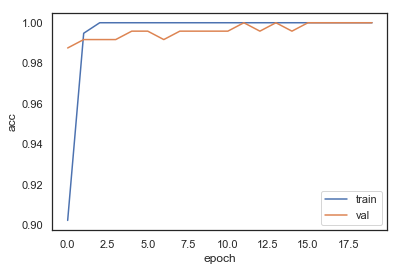

In [9]:
metric = 'acc' # 'loss' | 'acc'
plt.plot(hist.epoch, hist.history[metric], label='train')
plt.plot(hist.epoch, hist.history['val_{}'.format(metric)], label='val')
plt.xlabel('epoch')
plt.ylabel(metric)
plt.legend()

In [10]:
# apply the model to test data
p = lsc_fc2.predict(fc2_test)
p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
pred = np.argmax(p, axis=-1)
acc_vgg16 = round(accuracy_score(pred, y_test) * 100, 2)
print(acc_vgg16)

99.67


In [11]:
def evaluate_confusion_matrix(model, testdata, y_test):

    p = model.predict(testdata)
    p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
    pred = np.argmax(p, axis=-1)

    conf = confusion_matrix(y_test, pred)
    sns.heatmap(
        conf, annot=True, square=True, 
        mask=(conf == 0), linewidths=.5, linecolor='k',
        xticklabels=sorted(set(train_labels)),
        yticklabels=sorted(set(train_labels))
    )

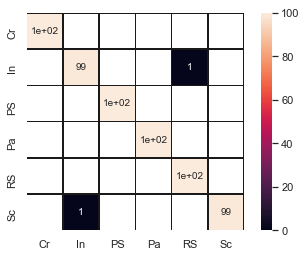

In [12]:
evaluate_confusion_matrix(lsc_fc2, fc2_test, y_test)

# 2. VGG19

The structure of VGG19 is as below.

In [13]:
model = vgg19.VGG19(weights=None)
print("model structure: ", model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
def preprocess_images_vgg19(images):
    """ expect a 3D array containing grayscale uint8 images """
    
    # resize images with scipy
    I = np.array([resize(image, (224,224)) for image in images])
    
    # convert to RGB and apply imagenet preprocessing
    I = gray2rgb(I).astype(np.float32)

    return vgg19.preprocess_input(I)


def vgg19_layer(output_name='fc1'):
    # Note: currently hippolyta compute nodes cannot access user home directories,
    # and do not have direct internet access.
    # use full paths to NFS filesystem endpoints (not symlinks)
    # keras pretrained model weight files are here:
    # KERAS_ROOT = 'D:\Python\CV Project\defect'
    # weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    # weights_path = os.path.join(KERAS_ROOT, 'models', weights_file)

    # initialize network with random weights, and load from hdf5
    cnn = vgg19.VGG19(include_top=True, weights='imagenet')
    #cnn.load_weights(filepath=weights_path)

    model = Model(inputs=cnn.input,outputs=cnn.get_layer(output_name).output)
    return model


def cached_forward_pass_vgg19(images, phase='train', layername='fc1', datadir='../data'):
        
    datafile = os.path.join(datadir, 'neu-vgg19-{}-{}.npy'.format(layername, phase))
    try:
        features = np.load(datafile)
    except FileNotFoundError:
        print('forward pass for NEU {}ing images'.format(phase))
        model = vgg19_layer(layername)
        features = model.predict(preprocess_images_vgg16(images), verbose=False)
        np.save(datafile, features)

    return features

In [15]:
datadir='D:\Python\CV Project\defect\data'

v19fc1_train = cached_forward_pass_vgg19(train_images, phase='train', layername='fc1', datadir=datadir)
v19fc1_test = cached_forward_pass_vgg19(test_images, phase='test', layername='fc1', datadir=datadir)

v19fc2_train = cached_forward_pass_vgg19(train_images, phase='train', layername='fc2', datadir=datadir)
v19fc2_test = cached_forward_pass_vgg19(test_images, phase='test', layername='fc2', datadir=datadir)

In [16]:
lsc_v19fc2 = linear_softmax_classifier(input_dim=4096)
opt = optimizers.Adam(lr=0.001)
lsc_v19fc2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

target = np_utils.to_categorical(y_train)

# shuffle training data to get shuffled validation data
ntrain = train_images.shape[0]
initial_shuf = np.random.permutation(ntrain)
X = v19fc2_train[initial_shuf]
y = target[initial_shuf]

hist = lsc_v19fc2.fit(X, y, validation_split=0.2, epochs=20)

Train on 960 samples, validate on 240 samples
Epoch 1/20
960/960 [==============================] - 7s 8ms/step - loss: 0.4207 - acc: 0.8646 - val_loss: 0.0657 - val_acc: 0.9958
Epoch 2/20
960/960 [==============================] - 0s 123us/step - loss: 0.0629 - acc: 0.9865 - val_loss: 0.0474 - val_acc: 0.9917
Epoch 3/20
960/960 [==============================] - 0s 236us/step - loss: 0.0356 - acc: 0.9927 - val_loss: 0.0369 - val_acc: 0.9917
Epoch 4/20
960/960 [==============================] - 0s 161us/step - loss: 0.0264 - acc: 0.9948 - val_loss: 0.0270 - val_acc: 0.9958
Epoch 5/20
960/960 [==============================] - 0s 220us/step - loss: 0.0182 - acc: 0.9979 - val_loss: 0.0218 - val_acc: 0.9958
Epoch 6/20
960/960 [==============================] - 0s 138us/step - loss: 0.0143 - acc: 0.9979 - val_loss: 0.0230 - val_acc: 0.9958
Epoch 7/20
960/960 [==============================] - 0s 141us/step - loss: 0.0134 - acc: 0.9990 - val_loss: 0.0181 - val_acc: 0.9958
Epoch 8/20
960/960

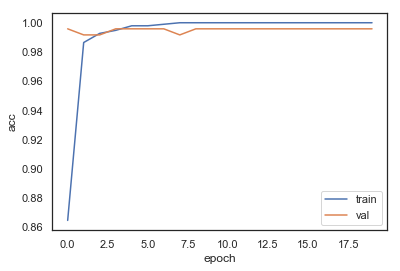

In [17]:
metric = 'acc' # 'loss' | 'acc'
plt.plot(hist.epoch, hist.history[metric], label='train')
plt.plot(hist.epoch, hist.history['val_{}'.format(metric)], label='val')
plt.xlabel('epoch')
plt.ylabel(metric)
plt.legend()

In [18]:
# apply the model to test data
p = lsc_v19fc2.predict(v19fc2_test)
p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
pred = np.argmax(p, axis=-1)
acc_vgg19 = round(accuracy_score(pred, y_test) * 100, 2)
print(acc_vgg19)

99.67


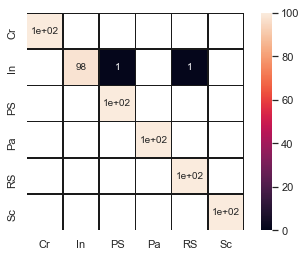

In [19]:
evaluate_confusion_matrix(lsc_v19fc2, v19fc2_test, y_test)

# 3. InceptionV3

The structure of InceptionV3 is as below.

In [20]:
model = inception_v3.InceptionV3(weights=None)
print("model structure: ", model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [21]:
def preprocess_images_inception(images):
    """ expect a 3D array containing grayscale uint8 images """

    # resize images with scipy
    I = np.array([resize(image, (224,224)) for image in images])

    # convert to RGB and apply imagenet preprocessing
    I = gray2rgb(I).astype(np.float32)

    return inception_v3.preprocess_input(I)

def inception_layer(output_name='avg_pool'):
    # Note: currently hippolyta compute nodes cannot access user home directories,
    # and do not have direct internet access.
    # use full paths to NFS filesystem endpoints (not symlinks)
    # keras pretrained model weight files are here:
    #KERAS_ROOT = 'D:\Python\CV Project\defect'
    #weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    #weights_path = os.path.join(KERAS_ROOT, 'models', weights_file)

    # initialize network with random weights, and load from hdf5
    cnn = inception_v3.InceptionV3(include_top=True, weights='imagenet', classes=1000)
    #cnn.load_weights(filepath=weights_path)

    model = Model(
        inputs=cnn.input,
        outputs=cnn.get_layer(output_name).output
    )

    return model


def cached_forward_pass_inception(images, phase='train', layername='avg_pool', datadir='../data'):
        
    datafile = os.path.join(datadir, 'neu-inception-{}-{}.npy'.format(layername, phase))
    try:
        features = np.load(datafile)
    except FileNotFoundError:
        print('forward pass for NEU {}ing images'.format(phase))
        model = inception_layer(layername)
        features = model.predict(preprocess_images_inception(images), verbose=True)
        np.save(datafile, features)

    return features

In [22]:
datadir='D:\Python\CV Project\defect\data'

ap_train = cached_forward_pass_inception(train_images, phase='train', layername='avg_pool', datadir=datadir)
ap_test = cached_forward_pass_inception(test_images, phase='test', layername='avg_pool', datadir=datadir)

In [23]:
ntrain = train_images.shape[0]

lsc_ap = linear_softmax_classifier(input_dim=2048)
opt = optimizers.Adam(lr=0.01)
lsc_ap.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

target = np_utils.to_categorical(y_train)

# shuffle training data to get shuffled validation data
initial_shuf = np.random.permutation(ntrain)
X = ap_train[initial_shuf]
y = target[initial_shuf]

hist = lsc_ap.fit(X, y, validation_split=0.2, epochs=100)

Train on 960 samples, validate on 240 samples
Epoch 1/100
960/960 [==============================] - 9s 9ms/step - loss: 1.7590 - acc: 0.3302 - val_loss: 1.3003 - val_acc: 0.4667
Epoch 2/100
960/960 [==============================] - 0s 246us/step - loss: 1.1360 - acc: 0.5865 - val_loss: 0.9056 - val_acc: 0.7875
Epoch 3/100
960/960 [==============================] - 0s 306us/step - loss: 0.9544 - acc: 0.6854 - val_loss: 0.8844 - val_acc: 0.7292
Epoch 4/100
960/960 [==============================] - 0s 233us/step - loss: 0.8483 - acc: 0.7302 - val_loss: 0.7610 - val_acc: 0.7292
Epoch 5/100
960/960 [==============================] - 0s 189us/step - loss: 0.8123 - acc: 0.7010 - val_loss: 0.6648 - val_acc: 0.8208
Epoch 6/100
960/960 [==============================] - 0s 200us/step - loss: 0.6931 - acc: 0.8021 - val_loss: 0.6563 - val_acc: 0.8583
Epoch 7/100
960/960 [==============================] - 0s 261us/step - loss: 0.6628 - acc: 0.7937 - val_loss: 0.5613 - val_acc: 0.8250
Epoch 8/100

Epoch 61/100
960/960 [==============================] - 0s 103us/step - loss: 0.2151 - acc: 0.9323 - val_loss: 0.1989 - val_acc: 0.9375
Epoch 62/100
960/960 [==============================] - 0s 104us/step - loss: 0.1875 - acc: 0.9469 - val_loss: 0.1836 - val_acc: 0.9333
Epoch 63/100
960/960 [==============================] - 0s 103us/step - loss: 0.2027 - acc: 0.9448 - val_loss: 0.2078 - val_acc: 0.9542
Epoch 64/100
960/960 [==============================] - 0s 101us/step - loss: 0.1802 - acc: 0.9490 - val_loss: 0.1858 - val_acc: 0.9375
Epoch 65/100
960/960 [==============================] - 0s 106us/step - loss: 0.1694 - acc: 0.9583 - val_loss: 0.1827 - val_acc: 0.9458
Epoch 66/100
960/960 [==============================] - 0s 103us/step - loss: 0.1805 - acc: 0.9510 - val_loss: 0.1939 - val_acc: 0.9417
Epoch 67/100
960/960 [==============================] - 0s 167us/step - loss: 0.1930 - acc: 0.9438 - val_loss: 0.2187 - val_acc: 0.9292
Epoch 68/100
960/960 [==========================

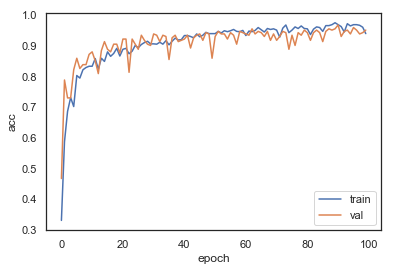

In [24]:
metric = 'acc' # 'loss' | 'acc'
plt.plot(hist.epoch, hist.history[metric], label='train')
plt.plot(hist.epoch, hist.history['val_{}'.format(metric)], label='val')
plt.xlabel('epoch')
plt.ylabel(metric)
plt.legend()

In [25]:
# apply the model to test data
p = lsc_ap.predict(ap_test)
p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
pred = np.argmax(p, axis=-1)
acc_inception = round(accuracy_score(pred, y_test) * 100, 2)
print(acc_inception)

91.67


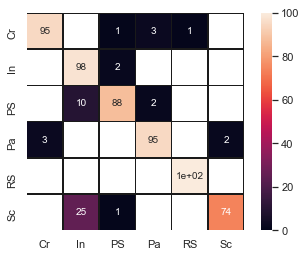

In [26]:
evaluate_confusion_matrix(lsc_ap, ap_test, y_test)

# 4. ResNet50

The structure of ResNet50 is as below.

In [27]:
model = resnet50.ResNet50(weights=None)
print("model structure: ", model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [28]:
def preprocess_images_resnet(images):
    """ expect a 3D array containing grayscale uint8 images """

    # resize images with scipy
    I = np.array([resize(image, (224,224)) for image in images])

    # convert to RGB and apply imagenet preprocessing
    I = gray2rgb(I).astype(np.float32)

    return resnet50.preprocess_input(I)

def resnet_layer(output_name='avg_pool'):
    # Note: currently hippolyta compute nodes cannot access user home directories,
    # and do not have direct internet access.
    # use full paths to NFS filesystem endpoints (not symlinks)
    # keras pretrained model weight files are here:
    #KERAS_ROOT = 'D:\Python\CV Project\defect'
    #weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    #weights_path = os.path.join(KERAS_ROOT, 'models', weights_file)

    # initialize network with random weights, and load from hdf5
    cnn = resnet50.ResNet50(include_top=True, weights='imagenet', classes=1000)
    #cnn.load_weights(filepath=weights_path)

    model = Model(
        inputs=cnn.input,
        outputs=cnn.get_layer(output_name).output
    )

    return model


def cached_forward_pass_resnet(images, phase='train', layername='avg_pool', datadir='../data'):
        
    datafile = os.path.join(datadir, 'neu-resnet-{}-{}.npy'.format(layername, phase))
    try:
        features = np.load(datafile)
    except FileNotFoundError:
        print('forward pass for NEU {}ing images'.format(phase))
        model = inception_layer(layername)
        features = model.predict(preprocess_images_resnet(images), verbose=True)
        np.save(datafile, features)

    return features

In [29]:
datadir='D:\Python\CV Project\defect\data'

rnap_train = cached_forward_pass_resnet(train_images, phase='train', layername='avg_pool', datadir=datadir)
rnap_test = cached_forward_pass_resnet(test_images, phase='test', layername='avg_pool', datadir=datadir)

In [30]:
ntrain = train_images.shape[0]

lsc_rnap = linear_softmax_classifier(input_dim=2048)
opt = optimizers.Adam(lr=0.01)
lsc_rnap.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

target = np_utils.to_categorical(y_train)

# shuffle training data to get shuffled validation data
initial_shuf = np.random.permutation(ntrain)
X = rnap_train[initial_shuf]
y = target[initial_shuf]

hist = lsc_rnap.fit(X, y, validation_split=0.2, epochs=300)

Train on 960 samples, validate on 240 samples
Epoch 1/300
960/960 [==============================] - 7s 7ms/step - loss: 1.9567 - acc: 0.1813 - val_loss: 1.7487 - val_acc: 0.1667
Epoch 2/300
960/960 [==============================] - 0s 151us/step - loss: 1.7622 - acc: 0.2552 - val_loss: 1.7442 - val_acc: 0.2667
Epoch 3/300
960/960 [==============================] - 0s 135us/step - loss: 1.7140 - acc: 0.2500 - val_loss: 1.7192 - val_acc: 0.2125
Epoch 4/300
960/960 [==============================] - 0s 158us/step - loss: 1.6962 - acc: 0.2896 - val_loss: 1.6795 - val_acc: 0.2458
Epoch 5/300
960/960 [==============================] - 0s 117us/step - loss: 1.6312 - acc: 0.3365 - val_loss: 1.6025 - val_acc: 0.3292
Epoch 6/300
960/960 [==============================] - 0s 112us/step - loss: 1.6184 - acc: 0.3375 - val_loss: 1.5958 - val_acc: 0.3250
Epoch 7/300
960/960 [==============================] - 0s 111us/step - loss: 1.6244 - acc: 0.3281 - val_loss: 1.7227 - val_acc: 0.2917
Epoch 8/300

Epoch 61/300
960/960 [==============================] - 0s 147us/step - loss: 1.1364 - acc: 0.5635 - val_loss: 1.1588 - val_acc: 0.6292
Epoch 62/300
960/960 [==============================] - 0s 133us/step - loss: 1.0649 - acc: 0.6302 - val_loss: 1.1270 - val_acc: 0.6792
Epoch 63/300
960/960 [==============================] - 0s 152us/step - loss: 1.0505 - acc: 0.6677 - val_loss: 1.1697 - val_acc: 0.4333
Epoch 64/300
960/960 [==============================] - 0s 157us/step - loss: 1.0847 - acc: 0.6135 - val_loss: 1.1621 - val_acc: 0.5083
Epoch 65/300
960/960 [==============================] - 0s 145us/step - loss: 1.1024 - acc: 0.5594 - val_loss: 1.1600 - val_acc: 0.6208
Epoch 66/300
960/960 [==============================] - 0s 161us/step - loss: 1.0583 - acc: 0.6417 - val_loss: 1.0648 - val_acc: 0.6708
Epoch 67/300
960/960 [==============================] - 0s 143us/step - loss: 1.0119 - acc: 0.6750 - val_loss: 1.1721 - val_acc: 0.5250
Epoch 68/300
960/960 [==========================

960/960 [==============================] - 0s 125us/step - loss: 1.0182 - acc: 0.6323 - val_loss: 1.3333 - val_acc: 0.4083
Epoch 122/300
960/960 [==============================] - 0s 121us/step - loss: 0.9569 - acc: 0.6729 - val_loss: 1.0130 - val_acc: 0.6208
Epoch 123/300
960/960 [==============================] - 0s 122us/step - loss: 0.8750 - acc: 0.7260 - val_loss: 1.0593 - val_acc: 0.5958
Epoch 124/300
960/960 [==============================] - 0s 124us/step - loss: 0.8640 - acc: 0.7448 - val_loss: 0.9527 - val_acc: 0.7000
Epoch 125/300
960/960 [==============================] - 0s 133us/step - loss: 0.8745 - acc: 0.7146 - val_loss: 1.0049 - val_acc: 0.6375
Epoch 126/300
960/960 [==============================] - 0s 144us/step - loss: 0.9154 - acc: 0.6844 - val_loss: 0.9564 - val_acc: 0.7208
Epoch 127/300
960/960 [==============================] - 0s 142us/step - loss: 0.8886 - acc: 0.6698 - val_loss: 0.9920 - val_acc: 0.6917
Epoch 128/300
960/960 [==============================] 

Epoch 181/300
960/960 [==============================] - 0s 155us/step - loss: 0.8010 - acc: 0.7219 - val_loss: 0.8878 - val_acc: 0.6417
Epoch 182/300
960/960 [==============================] - 0s 159us/step - loss: 0.7850 - acc: 0.7417 - val_loss: 0.9412 - val_acc: 0.6917
Epoch 183/300
960/960 [==============================] - 0s 138us/step - loss: 0.7690 - acc: 0.7656 - val_loss: 0.8927 - val_acc: 0.6917
Epoch 184/300
960/960 [==============================] - 0s 184us/step - loss: 0.7891 - acc: 0.7615 - val_loss: 1.1010 - val_acc: 0.6625
Epoch 185/300
960/960 [==============================] - 0s 150us/step - loss: 0.8255 - acc: 0.7240 - val_loss: 0.9698 - val_acc: 0.6125
Epoch 186/300
960/960 [==============================] - 0s 166us/step - loss: 0.7991 - acc: 0.7167 - val_loss: 0.9616 - val_acc: 0.6125
Epoch 187/300
960/960 [==============================] - 0s 172us/step - loss: 0.7498 - acc: 0.7792 - val_loss: 0.8269 - val_acc: 0.7917
Epoch 188/300
960/960 [==================

Epoch 241/300
960/960 [==============================] - 0s 169us/step - loss: 0.6925 - acc: 0.7958 - val_loss: 0.8369 - val_acc: 0.6583
Epoch 242/300
960/960 [==============================] - 0s 172us/step - loss: 0.6845 - acc: 0.7771 - val_loss: 0.7865 - val_acc: 0.7917
Epoch 243/300
960/960 [==============================] - 0s 175us/step - loss: 0.7065 - acc: 0.8010 - val_loss: 0.8101 - val_acc: 0.7667
Epoch 244/300
960/960 [==============================] - 0s 172us/step - loss: 0.6786 - acc: 0.8021 - val_loss: 0.7762 - val_acc: 0.7750
Epoch 245/300
960/960 [==============================] - 0s 162us/step - loss: 0.7220 - acc: 0.7677 - val_loss: 0.8444 - val_acc: 0.6583
Epoch 246/300
960/960 [==============================] - 0s 163us/step - loss: 0.6867 - acc: 0.7906 - val_loss: 0.8026 - val_acc: 0.7292
Epoch 247/300
960/960 [==============================] - 0s 189us/step - loss: 0.6940 - acc: 0.7896 - val_loss: 0.8752 - val_acc: 0.7375
Epoch 248/300
960/960 [==================

960/960 [==============================] - 0s 119us/step - loss: 0.6662 - acc: 0.7865 - val_loss: 0.7482 - val_acc: 0.8083


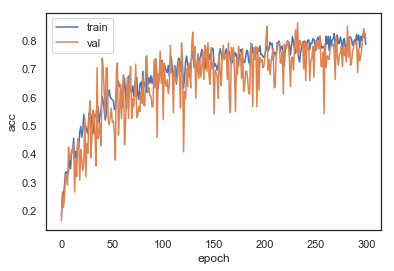

In [31]:
metric = 'acc' # 'loss' | 'acc'
plt.plot(hist.epoch, hist.history[metric], label='train')
plt.plot(hist.epoch, hist.history['val_{}'.format(metric)], label='val')
plt.xlabel('epoch')
plt.ylabel(metric)
plt.legend()

In [32]:
# apply the model to test data
p = lsc_rnap.predict(rnap_test)
p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
pred = np.argmax(p, axis=-1)
acc_resnet = round(accuracy_score(pred, y_test) * 100, 2)
print(acc_resnet)

81.5


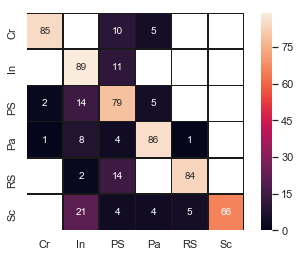

In [33]:
evaluate_confusion_matrix(lsc_rnap, rnap_test, y_test)